In [2]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from copy import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle
import warnings
import torch
import scipy
from scipy import optimize
from scipy.optimize import leastsq
from io import StringIO
from scipy.signal import savgol_filter
from datetime import datetime
from matplotlib import cm
#from colorspacious import cspace_converter
from collections import OrderedDict


now = datetime.now()
d_string = now.strftime("%d.%m.%Y")

%run Functions.ipynb



<Figure size 432x288 with 0 Axes>

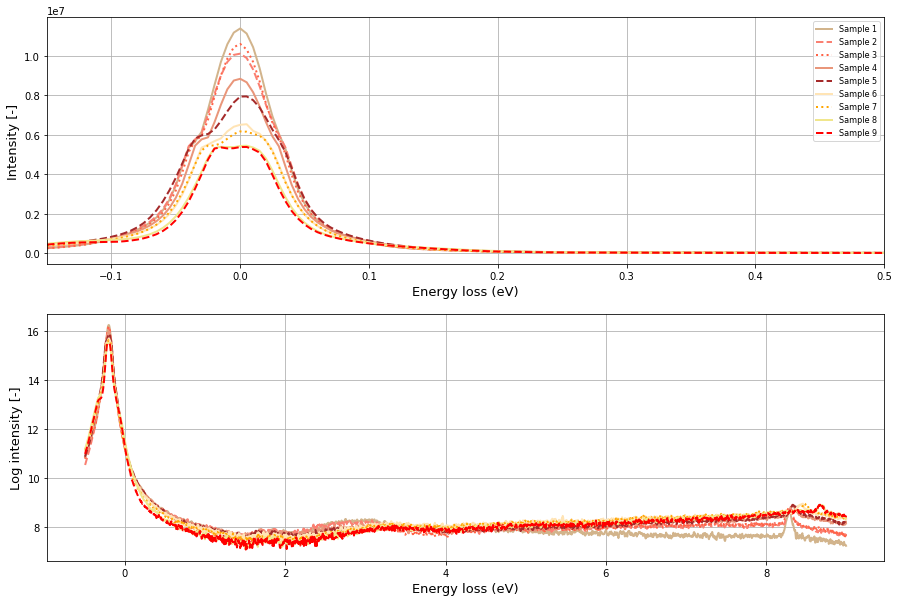

In [3]:
%run EELS-ZLP-May.py

In [4]:
ZLP_data = pd.DataFrame({"x1": x1 + 0.2025, "y1": y1, "log(y1)": np.log(y1), "x2": x2+ 0.2025, "y2": y2, "log(y2)": log_y2, "x3": x3+ 0.2025, "y3": y3, "log(y3)": log_y3, "x4": x4+ 0.2025, "y4": y4, "log(y4)": log_y4, "x5": x5+ 0.2025, "y5": y5, "log(y5)": log_y5, "x6": x6+ 0.2025, "y6": y6, "log(y6)": log_y6, "x7": x7+ 0.2025, "y7": y7, "log(y7)": log_y7, "x8": x8+0.2025, "y8": y8, "log(y8)": log_y8, "y9": y9+0.2025, "log(y9)": log_y9 })
ZLP_data

,x1,y1,log(y1),x2,y2,log(y2),x3,y3,log(y3),x4,...,y6,log(y6),x7,y7,log(y7),x8,y8,log(y8),y9,log(y9)
0,-0.295,51009.40,10.839765,-0.295,37132.30,10.522242,-0.295,47761.90,10.773984,-0.295,...,67786.80,11.124123,-0.295,69074.80,11.142945,-0.295,70938.70,11.169571,58325.3025,10.973788
1,-0.290,53958.40,10.895969,-0.290,39514.20,10.584415,-0.290,50650.30,10.832700,-0.290,...,70441.60,11.162539,-0.290,72512.90,11.191520,-0.290,75132.60,11.227010,62443.6025,11.042016
2,-0.285,57218.70,10.954636,-0.285,41907.80,10.643227,-0.285,53527.70,10.887955,-0.285,...,73634.10,11.206864,-0.285,76263.10,11.241944,-0.285,80328.40,11.293879,66668.7025,11.107488
3,-0.280,60768.20,11.014822,-0.280,44538.10,10.704100,-0.280,56778.10,10.946906,-0.280,...,78020.70,11.264729,-0.280,79955.50,11.289226,-0.280,85249.40,11.353336,69547.8025,11.149767
4,-0.275,64236.40,11.070325,-0.275,47017.30,10.758271,-0.275,59842.00,10.999463,-0.275,...,81393.10,11.307046,-0.275,83668.60,11.334619,-0.275,89419.10,11.401090,73172.2025,11.200568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1895,9.180,1486.28,7.304032,9.180,2355.55,7.764530,9.180,2043.92,7.622625,9.180,...,4183.47,8.338896,9.180,3930.01,8.276397,9.180,4312.14,8.369190,4689.9625,8.453137
1896,9.185,1413.24,7.253640,9.185,2345.68,7.760331,9.185,1927.29,7.563870,9.185,...,4330.02,8.373327,9.185,4089.59,8.316200,9.185,4350.82,8.378120,4270.0625,8.359336
1897,9.190,1415.09,7.254948,9.190,2176.51,7.685478,9.190,2119.88,7.659115,9.190,...,4316.34,8.370163,9.190,4231.09,8.350215,9.190,4452.78,8.401284,4222.1425,8.348050
1898,9.195,1416.13,7.255683,9.195,2053.65,7.627374,9.195,2215.33,7.703157,9.195,...,3917.24,8.273143,9.195,4171.29,8.335981,9.195,4419.25,8.393725,4203.6525,8.343661


## Load predictions and training data

- Load the data files of today
- Select the ones that are good, based on a minimum $\chi^2_{test}$
- Only keep the good ones to make predictions


In [591]:
d_string = '03.06.2020'

path_1 = r'Data/Results/%(now)s/' % {"now": d_string} # use your path
round_no = 'x1'
path_data = r'*_xyp1p2_*.csv'
path_chi = r'*_chi_*.csv' 
path_pred = path_4 = r'*_extrapolation_*'

all_files = glob.glob(path_1 + round_no+ path_data)
li = []
for filename in all_files:
    df = pd.read_csv(filename, delimiter=",", skiprows=0, header=None, usecols=[0,1,2], names=['x', 'y', 'pred'])
    li.append(df)
frame = pd.concat(li, axis=0, ignore_index=True)


In [592]:
# Put all data in a dataframe

training_data = pd.DataFrame()
training_data['x'] = frame.iloc[:,0]
training_data['y'] = frame.iloc[:,1]
training_data['prediction'] = frame.iloc[:,2]

training_data.describe()

,x,y,prediction
count,33480.000000,33480.000000,33480.000000
mean,0.773249,10.087538,9.991479
std,1.717299,3.967675,3.621705
min,-0.290000,0.410882,0.566170
25%,-0.015000,8.886135,8.990565
50%,0.262500,10.493942,9.974358
75%,0.550000,12.766780,12.170741
max,8.000000,16.499361,16.299292


In [593]:
all_files_chi = glob.glob(path_1 + round_no + path_chi)

all_files_chi_sort = np.sort(all_files_chi)
chi2_array = []
chi2_index = []

for filename in all_files_chi_sort:
    df = pd.read_csv(filename, delimiter=",", skiprows=0, header=None, usecols=[0,1])
    best_try = np.argmin(df[1])
    chi2_array.append(df.iloc[best_try,1])
    chi2_index.append(best_try)

chi_data  = pd.DataFrame()
chi_data['Best chi2 value'] = chi2_array
chi_data['Epoch'] = chi2_index
    
print("total length of files:", len(chi2_array))

/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:61: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return bound(*args, **kwds)


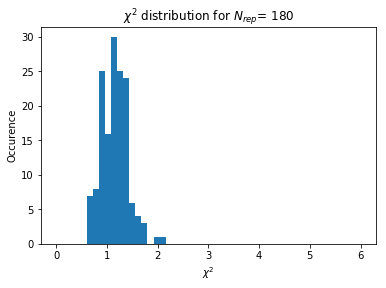

In [594]:
plt.hist(chi_data['Best chi2 value'], bins=50, range=[0, 6])
plt.title('$\chi^2$ distribution for $N_{rep}$= %(s)s' % {"s": len(chi2_array)})
plt.xlabel('$\chi^2$')
plt.ylabel('Occurence')
plt.savefig('Data/Results/histogram.png')
plt.show()

## Post-selection criteria

In [595]:
good_files = []
count = 0
selection_min = 1.5
for i,j in enumerate(chi2_array):
    
    if j < selection_min:
        good_files.append('Keep') 
        count +=1 
    else:
        good_files.append('Discard')

print("The number of files that survived the selection is", count)

## Load extrapolation data

For each replica, the prediction should be taken separately:\
     $substracted\_spectrum_k = original\_spectrum - ZLP_k$

In [596]:
all_files_ex = glob.glob(path_1 + round_no + path_pred)
all_files_ex_sort = np.sort(all_files_ex)
use_files = []

## Use original ZLP data to substract:
original = ZLP_data[(ZLP_data['x1'] >= -.3) & (ZLP_data['x1'] <= 3)]

for i,j in enumerate(good_files):
    if j == 'Keep':
        file = all_files_ex_sort[i]
        use_files.append(file)
        
        

## Matching of ZLP and data region

In [597]:
dE1 = max(training_data['x'][(training_data['x']< 1)])
dE2 = min(training_data['x'][(training_data['x']> 1)])
dE0 = dE1 - 0.3

In [598]:
def matching(x, y_NN, y_ZLP):
    

    
    total = pd.DataFrame({"x": x, "prediction y": y_NN, "data y1": y_ZLP})
    delta = np.divide((dE1 - dE0), 5)
    
    factor_NN = np.exp(-np.divide((x[(x<dE1) & (x >= dE0)] - dE1)**2, delta**2))
    factor_ZLP = 1 -factor_NN
    range_0 = total[total['x'] < dE0]['data y1'] * 1
    range_1 = total[(total['x'] < dE1) & (total['x'] >= dE0)]['prediction y'] * factor_NN  + total[(total['x'] < dE1) & (total['x'] >= dE0)]['data y1'] * factor_ZLP
    range_2 = total[total['x'] >= dE1]['prediction y'] * 1 
    totalfile = np.concatenate((range_0, range_1, range_2), axis=0)
    
    return totalfile


In [599]:
nbins = 660        
li = []
diff = []
count = 0

for filename in use_files:
    df = pd.read_csv(filename, delimiter=",", header=None, usecols=[0,1], names=['x', 'prediction'])
    df['k'] = count
    li.append(df)
    count += 1
    
extrapolation = pd.concat(li, axis=0, ignore_index=True)

lo = []

for k in range(count): 
    exp_k = extrapolation[extrapolation['k'] == k ]
    
    mean_k, var_k, count = binned_statistics(exp_k['x'], exp_k['prediction'], nbins)[0:3]
    
    
    replica_file = pd.DataFrame({"k": k, "x1": original['x1'], "data log(y1)": original['log(y1)'], \
                               "prediction log(y1)": mean_k, \
                               "prediction y": np.exp(mean_k), \
                               "data y1": original['y1'],  \
                               "data y2": original['y2'], \
                               "data y3": original['y3'],  \
                               "data y4": original['y4'], \
                               "data y5": original['y5'],  \
                               "data y6": original['y6'], \
                               "data y7": original['y7'],  \
                               "data y8": original['y8'],  \
                               "data y9": original['y9'],  \
                                 "dif1": (original['y1'] - np.exp(mean_k)), \
                                 "dif2": (original['y2'] - np.exp(mean_k)), \
                                 "dif3": (original['y3'] - np.exp(mean_k)), \
                                 "dif4": (original['y4'] - np.exp(mean_k)), \
                                 "dif5": (original['y5'] - np.exp(mean_k)), \
                                 "dif6": (original['y6'] - np.exp(mean_k)), \
                                 "dif7": (original['y7'] - np.exp(mean_k)), \
                                 "dif8": (original['y8'] - np.exp(mean_k)), \
                                 "dif9": (original['y9'] - np.exp(mean_k)), \
                                     "match1": matching(original['x1'], np.exp(mean_k), original['y1']), \
                                     "match2": matching(original['x1'], np.exp(mean_k), original['y2']), \
                                     "match3": matching(original['x1'], np.exp(mean_k), original['y3']), \
                                     "match4": matching(original['x1'], np.exp(mean_k), original['y4']), \
                                     "match5": matching(original['x1'], np.exp(mean_k), original['y5']), \
                                     "match6": matching(original['x1'], np.exp(mean_k), original['y6']), \
                                     "match7": matching(original['x1'], np.exp(mean_k), original['y7']), \
                                     "match8": matching(original['x1'], np.exp(mean_k), original['y8']), \
                                     "match9": matching(original['x1'], np.exp(mean_k), original['y9'])
                                })
    lo.append(replica_file)
    
total_replicas = pd.concat(lo, axis=0, ignore_index = True, sort=False)

## One big super file with all the data

In [600]:
total_replicas.describe()

,k,x1,data log(y1),prediction log(y1),prediction y,data y1,data y2,data y3,data y4,data y5,...,dif9,match1,match2,match3,match4,match5,match6,match7,match8,match9
count,89100.000000,89100.000000,89100.000000,89100.000000,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,...,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04,8.910000e+04
mean,67.000000,1.352500,8.957401,5.108902,2.249684e+05,2.878711e+05,2.773078e+05,2.729700e+05,2.469745e+05,2.590034e+05,...,-5.314449e+04,2.860615e+05,2.754559e+05,2.715049e+05,2.453233e+05,2.573861e+05,2.078619e+05,2.034189e+05,1.804226e+05,1.707162e+05
std,38.970293,0.952632,1.989275,4.634013,9.946875e+05,1.366356e+06,1.276849e+06,1.281877e+06,1.104719e+06,1.098032e+06,...,3.052658e+05,1.366734e+06,1.277248e+06,1.282187e+06,1.105085e+06,1.098410e+06,8.909668e+05,8.673753e+05,7.499132e+05,7.295802e+05
min,0.000000,-0.295000,7.494514,0.133573,1.142905e+00,1.798150e+03,1.939520e+03,1.507360e+03,1.555430e+03,1.758690e+03,...,-7.269616e+06,1.142905e+00,1.142905e+00,1.142905e+00,1.142905e+00,1.142905e+00,1.142905e+00,1.142905e+00,1.142905e+00,1.142905e+00
25%,33.000000,0.528750,7.779237,1.151095,3.161652e+00,2.390450e+03,2.508785e+03,1.999650e+03,2.286350e+03,2.251528e+03,...,-2.603091e+02,3.161652e+00,3.161652e+00,3.161652e+00,3.161652e+00,3.161652e+00,3.161652e+00,3.161652e+00,3.161652e+00,3.161652e+00
50%,67.000000,1.352500,8.103547,2.223474,9.239374e+00,3.306175e+03,3.248200e+03,2.598170e+03,2.796980e+03,2.658090e+03,...,1.602515e+03,9.239374e+00,9.239374e+00,9.239374e+00,9.239374e+00,9.239374e+00,9.239374e+00,9.239374e+00,9.239374e+00,9.239374e+00
75%,101.000000,2.176250,9.101311,8.983438,7.969985e+03,8.967055e+03,8.743978e+03,8.199767e+03,8.475975e+03,8.322830e+03,...,1.908583e+03,8.966898e+03,8.743983e+03,8.200414e+03,8.476000e+03,8.323330e+03,7.793201e+03,7.197202e+03,6.105430e+03,5.457301e+03
max,134.000000,3.000000,16.246920,16.352540,1.264207e+07,1.137490e+07,1.009710e+07,1.059160e+07,8.824970e+06,7.933170e+06,...,1.968758e+06,1.137490e+07,1.009710e+07,1.059160e+07,8.824970e+06,7.933170e+06,6.525230e+06,6.160050e+06,5.436550e+06,5.372450e+06


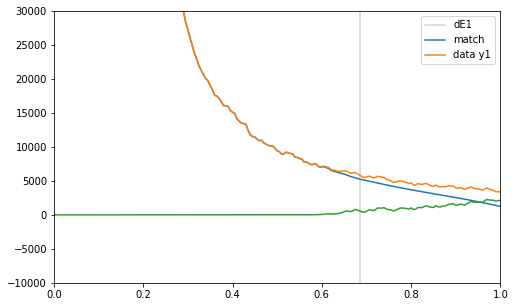

In [601]:
plt.figure(figsize=(8,5))
plt.axvline(x=dE1, color='lightgray', label='dE1')
plt.plot(total_replicas['x1'][0:400], total_replicas['match1'][0:400], label='match')
plt.plot(total_replicas['x1'][0:400], total_replicas['data y1'][0:400])
plt.plot(total_replicas['x1'][0:400], total_replicas['data y1'][0:400] - total_replicas['match1'][0:400])
#plt.plot(total_replicas['x1'][0:400], total_replicas['prediction y'][0:400])
plt.legend()
plt.xlim([0,1])
plt.ylim([-1e4, 3e4])

plt.show()


### Sample/ZLP ratio

In [602]:
sample_intensity = total_replicas['data y1']
ZLP_intensity = total_replicas['prediction y']
nbins = 400

ratio = np.divide(sample_intensity, ZLP_intensity)
sample_zlp_ratio = pd.DataFrame()
sample_zlp_ratio['x'] =  total_replicas['x1']
sample_zlp_ratio['ratio'] = ratio

## Only take values > 0.1 eV
sample_zlp_ratio = sample_zlp_ratio[sample_zlp_ratio['x'] > .1].reset_index()
sample_zlp_ratio=sample_zlp_ratio.drop('index', axis=1)

Text(17.75, 0.5, 'Ratio')

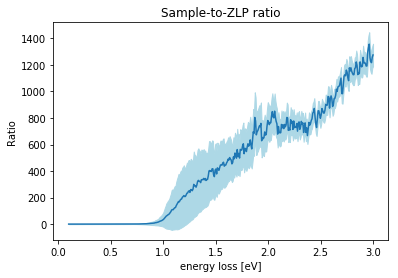

In [603]:
mean_ratio, var_ratio, count_ratio = \
binned_statistics(sample_zlp_ratio['x'],  sample_zlp_ratio['ratio'], nbins)[0:3]

plt.fill_between(np.linspace(.1, 3, nbins), mean_ratio+var_ratio, mean_ratio-var_ratio, color='lightblue')
plt.plot(np.linspace(.1, 3, nbins), mean_ratio)

plt.title('Sample-to-ZLP ratio')
plt.xlabel('energy loss [eV]')
plt.savefig('Data/Results/Ratio.png')
plt.ylabel('Ratio')

Text(0.5, 15.0, 'energy loss [eV]')

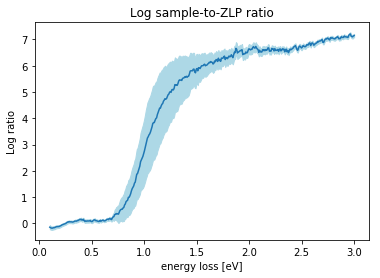

In [604]:
mean_ratio, var_ratio, count_ratio = \
binned_statistics(sample_zlp_ratio['x'],  np.log(sample_zlp_ratio['ratio']), nbins)[0:3]

plt.fill_between(np.linspace(.1, 3, nbins), mean_ratio+var_ratio, mean_ratio-var_ratio, color = 'lightblue')
plt.plot(np.linspace(.1, 3, nbins), mean_ratio)
plt.title('Log sample-to-ZLP ratio')
plt.savefig('Data/Results/Logratio.png')
plt.ylabel('Log ratio')
plt.xlabel('energy loss [eV]')

## File with average prediction data


For each replica $k$, the NN gives a prediction on the ZLP: $ZLP_k$. The substracted spectrum at each iteration is then $Substraction_k = original\_spectrum - ZLP_k$.  

In [605]:
nbins = 400

mean_replicas_dif, var_replicas_dif, count_replicas_dif = \
binned_statistics(total_replicas['x1'],  (total_replicas['data y1'] - total_replicas['prediction y']), nbins)[0:3]

mean_replicas_pred, var_replicas_pred, count_replicas_pred = \
binned_statistics(total_replicas['x1'], total_replicas['prediction y'], nbins)[0:3]


In [624]:
%run Functions.ipynb

mean_replicas = pd.DataFrame()
mean_replicas['x'] = np.linspace(-.3, 3, nbins)
mean_replicas['pred'] = mean_replicas_pred
mean_replicas['sigma_pred'] = var_replicas_pred
mean_replicas['median'] = get_median(total_replicas['x1'], total_replicas['prediction y'], nbins)
mean_replicas['y1'] = binned_statistics(total_replicas['x1'], total_replicas['data y1'], nbins)[0]
mean_replicas['y2'] = binned_statistics(total_replicas['x1'], total_replicas['data y2'], nbins)[0]
mean_replicas['y3'] = binned_statistics(total_replicas['x1'], total_replicas['data y3'], nbins)[0]
mean_replicas['y4'] = binned_statistics(total_replicas['x1'], total_replicas['data y4'], nbins)[0]
mean_replicas['y5'] = binned_statistics(total_replicas['x1'], total_replicas['data y5'], nbins)[0]
mean_replicas['y6'] = binned_statistics(total_replicas['x1'], total_replicas['data y6'], nbins)[0]
mean_replicas['y7'] = binned_statistics(total_replicas['x1'], total_replicas['data y7'], nbins)[0]
mean_replicas['y8'] = binned_statistics(total_replicas['x1'], total_replicas['data y8'], nbins)[0]
mean_replicas['y9'] = binned_statistics(total_replicas['x1'], total_replicas['data y9'], nbins)[0]

mean_replicas['match1'] = binned_statistics(total_replicas['x1'], total_replicas['match1'], nbins)[0]
mean_replicas['match2'] = binned_statistics(total_replicas['x1'], total_replicas['match2'], nbins)[0]
mean_replicas['match3'] = binned_statistics(total_replicas['x1'], total_replicas['match3'], nbins)[0]
mean_replicas['match4'] = binned_statistics(total_replicas['x1'], total_replicas['match4'], nbins)[0]
mean_replicas['match5'] = binned_statistics(total_replicas['x1'], total_replicas['match5'], nbins)[0]
mean_replicas['match6'] = binned_statistics(total_replicas['x1'], total_replicas['match6'], nbins)[0]
mean_replicas['match7'] = binned_statistics(total_replicas['x1'], total_replicas['match7'], nbins)[0]
mean_replicas['match8'] = binned_statistics(total_replicas['x1'], total_replicas['match8'], nbins)[0]
mean_replicas['match9'] = binned_statistics(total_replicas['x1'], total_replicas['match9'], nbins)[0]
### Confidence Interval
level = 0.68

mean_replicas['dif1'], mean_replicas['sigma_dif1'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y1'] - total_replicas['match1']), nbins)[0:2]
mean_replicas['low1'], mean_replicas['high1'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y1'] - total_replicas['match1']), nbins)[3:5]
mean_replicas['dif2'], mean_replicas['sigma_dif2'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y2'] - total_replicas['match2']), nbins)[0:2]
mean_replicas['low2'], mean_replicas['high2'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y2'] - total_replicas['match2']), nbins)[3:5]
mean_replicas['dif3'], mean_replicas['sigma_dif3'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y3'] - total_replicas['match3']), nbins)[0:2]
mean_replicas['low3'], mean_replicas['high3'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y3'] - total_replicas['match3']), nbins)[3:5]
mean_replicas['dif4'], mean_replicas['sigma_dif4'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y4'] - total_replicas['match4']), nbins)[0:2]
mean_replicas['low4'], mean_replicas['high4'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y4'] - total_replicas['match4']), nbins)[3:5]
mean_replicas['dif5'], mean_replicas['sigma_dif5'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y5'] - total_replicas['match5']), nbins)[0:2]
mean_replicas['low5'], mean_replicas['high5'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y5'] - total_replicas['match5']), nbins)[3:5]
mean_replicas['dif6'], mean_replicas['sigma_dif6'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y6'] - total_replicas['match6']), nbins)[0:2]
mean_replicas['low6'], mean_replicas['high6'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y6'] - total_replicas['match6']), nbins)[3:5]
mean_replicas['dif7'], mean_replicas['sigma_dif7'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y7'] - total_replicas['match7']), nbins)[0:2]
mean_replicas['low7'], mean_replicas['high7'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y7'] - total_replicas['match7']), nbins)[3:5]
mean_replicas['dif8'], mean_replicas['sigma_dif8'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y8'] - total_replicas['match8']), nbins)[0:2]
mean_replicas['low8'], mean_replicas['high8'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y8'] - total_replicas['match8']), nbins)[3:5]
mean_replicas['dif9'], mean_replicas['sigma_dif9'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y9'] - total_replicas['match9']), nbins)[0:2]
mean_replicas['low9'], mean_replicas['high9'] = binned_statistics(total_replicas['x1'],  \
                                          (total_replicas['data y9'] - total_replicas['match9']), nbins)[3:5]

mean_replicas['ratio1'] = np.divide(mean_replicas['dif1'], mean_replicas['sigma_pred'])
mean_replicas['ratio1_high'], mean_replicas['ratio1_low'] = \
    np.divide(mean_replicas['high1'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low1'], mean_replicas['sigma_pred']), 
mean_replicas['ratio2'] = np.divide(mean_replicas['dif2'], mean_replicas['sigma_pred'])
mean_replicas['ratio2_high'], mean_replicas['ratio2_low'] = \
    np.divide(mean_replicas['high2'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low2'], mean_replicas['sigma_pred']), 
mean_replicas['ratio3'] = np.divide(mean_replicas['dif3'], mean_replicas['sigma_pred'])
mean_replicas['ratio3_high'], mean_replicas['ratio3_low'] = \
    np.divide(mean_replicas['high3'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low3'], mean_replicas['sigma_pred']), 
mean_replicas['ratio4'] = np.divide(mean_replicas['dif4'], mean_replicas['sigma_pred'])
mean_replicas['ratio4_high'], mean_replicas['ratio4_low'] = \
    np.divide(mean_replicas['high4'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low4'], mean_replicas['sigma_pred']), 
mean_replicas['ratio5'] = np.divide(mean_replicas['dif5'], mean_replicas['sigma_pred'])
mean_replicas['ratio5_high'], mean_replicas['ratio5_low'] = \
    np.divide(mean_replicas['high5'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low5'], mean_replicas['sigma_pred']), 
mean_replicas['ratio6'] = np.divide(mean_replicas['dif6'], mean_replicas['sigma_pred'])
mean_replicas['ratio6_high'], mean_replicas['ratio6_low'] = \
    np.divide(mean_replicas['high6'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low6'], mean_replicas['sigma_pred']), 
mean_replicas['ratio7'] = np.divide(mean_replicas['dif7'], mean_replicas['sigma_pred'])
mean_replicas['ratio7_high'], mean_replicas['ratio7_low'] = \
    np.divide(mean_replicas['high7'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low7'], mean_replicas['sigma_pred']), 
mean_replicas['ratio8'] = np.divide(mean_replicas['dif8'], mean_replicas['sigma_pred'])
mean_replicas['ratio8_high'], mean_replicas['ratio8_low'] = \
    np.divide(mean_replicas['high8'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low8'], mean_replicas['sigma_pred']), 
mean_replicas['ratio9'] = np.divide(mean_replicas['dif9'], mean_replicas['sigma_pred'])
mean_replicas['ratio9_high'], mean_replicas['ratio9_low'] = \
    np.divide(mean_replicas['high9'], mean_replicas['sigma_pred']), np.divide(mean_replicas['low9'], mean_replicas['sigma_pred']), 


mean_replicas.describe()

/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:569: RuntimeWarning: invalid value encountered in sqrt
  (flatsum[a] / flatcount[a]) ** 2)
/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:569: RuntimeWarning: invalid value encountered in sqrt
  (flatsum[a] / flatcount[a]) ** 2)
/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:569: RuntimeWarning: invalid value encountered in sqrt
  (flatsum[a] / flatcount[a]) ** 2)
/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:569: RuntimeWarning: invalid value encountered in sqrt
  (flatsum[a] / flatcount[a]) ** 2)
/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/_binned_statistic.py:569: RuntimeWarning: invalid value encountered in sqrt
  (flatsum[a] / flatcount[a]) ** 2)
/Users/laurienroest/opt/anaconda3/lib/python3.7/site-packages/scipy/st

,x,pred,sigma_pred,median,y1,y2,y3,y4,y5,y6,...,ratio6_low,ratio7,ratio7_high,ratio7_low,ratio8,ratio8_high,ratio8_low,ratio9,ratio9_high,ratio9_low
count,400.000000,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,4.000000e+02,...,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,1.350000,2.272241e+05,2.710910e+04,2.263088e+05,2.911379e+05,2.802044e+05,2.764713e+05,2.504923e+05,2.610330e+05,2.111275e+05,...,2664.245999,2579.359911,2611.254733,2547.546318,2275.689504,2315.691274,2235.780209,2203.246767,2259.788628,2146.799317
std,0.956209,9.995585e+05,1.314146e+05,9.969341e+05,1.384672e+06,1.292850e+06,1.300637e+06,1.122697e+06,1.108324e+06,8.989461e+05,...,4001.486286,3857.749155,3903.309668,3813.215078,3459.657914,3513.908116,3407.492260,3346.772561,3427.334745,3270.480972
min,-0.300000,3.000441e+00,1.905013e-01,2.999519e+00,1.845915e+03,1.939520e+03,1.527785e+03,1.764565e+03,1.830230e+03,1.664500e+03,...,-0.948024,-1.228110,-0.600806,-1.749427,-3.654548,-2.665488,-4.502372,-3.739653,-2.830918,-4.594642
25%,0.525000,3.174248e+00,4.422346e-01,3.087050e+00,2.370072e+03,2.502543e+03,2.000768e+03,2.279644e+03,2.259312e+03,2.078021e+03,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.350000,1.784081e+01,2.378523e+01,8.996611e+00,3.305877e+03,3.218820e+03,2.594925e+03,2.814452e+03,2.650755e+03,2.557997e+03,...,94.610687,98.592427,101.343521,96.398135,76.448736,80.112115,73.444259,82.274049,84.197979,80.787494
75%,2.175000,7.914185e+03,8.145057e+02,7.875336e+03,9.018008e+03,8.711551e+03,8.151805e+03,8.454110e+03,8.195551e+03,7.813009e+03,...,4348.358689,4271.204308,4349.608956,4208.938623,3528.838454,3619.846686,3517.091802,3421.270110,3527.972188,3360.652758
max,3.000000,8.089837e+06,1.286874e+06,8.103425e+06,1.126960e+07,1.006615e+07,1.050675e+07,8.780870e+06,7.933170e+06,6.525230e+06,...,14817.574574,13498.623488,13617.039752,13474.562350,12250.617918,12724.762463,11824.079199,12762.592281,13045.991389,12479.071530


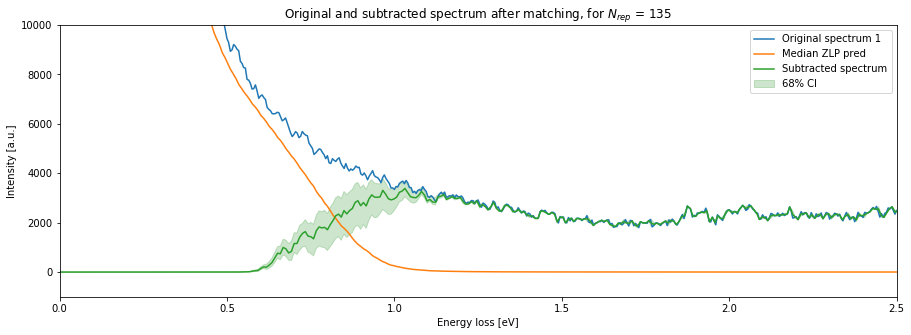

In [607]:
plt.figure(figsize=(15,5))
plt.plot(original['x1'], original['y1'], label='Original spectrum 1')
#plt.plot(mean_replicas['x'], mean_replicas['median'], label='median', color='goldenrod')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas['median'], label='Median ZLP pred')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas['dif1'], label='Subtracted spectrum')
plt.fill_between(np.linspace(-.3, 3, nbins), mean_replicas['high1'], \
                 mean_replicas['low1'], color='green',alpha=.2, label='68% CI')
plt.title("Original and subtracted spectrum after matching, for $N_{rep}$ = %(s)s" %{"s": len(use_files)})
plt.legend()
plt.xlim([0,2.5])
plt.ylim([-1e3, 1e4])
plt.xlabel('Energy loss [eV]')
plt.ylabel('Intensity [a.u.]')
plt.savefig('Data/Results/Subtracted_spectra(rescale).png')
plt.legend()
plt.show()

## Ratio Sample/sigma(ZLP)

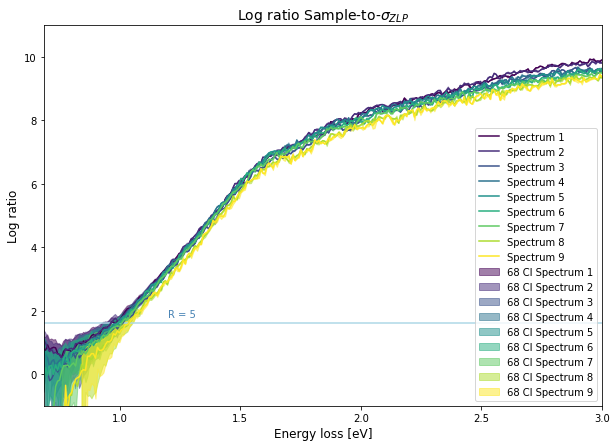

In [665]:
from matplotlib import cm
cm_subsection = np.linspace(0,1,9) 
colors = [ cm.viridis(x) for x in cm_subsection ]
plt.figure(figsize=(10,7))
plt.axhline(y= np.log(5), color='lightblue')
plt.text(1.2, np.log(5) + 0.2, s='R = 5', color='steelblue')
for i, color in enumerate(colors):
    function1 = mean_replicas['ratio%(k)s' %{"k": i+1}]
    function2 = mean_replicas['ratio%(k)s_high' %{"k": i+1}]
    function3 = mean_replicas['ratio%(k)s_low' %{"k": i+1}]
    plt.plot(np.linspace(-.3, 3, nbins), np.log(function1),  color = color, label='Spectrum %(k)s' %{"k": i+1})
    plt.fill_between(np.linspace(-.3, 3, nbins), np.log(function2), np.log(function3),  color = color, alpha=.5, label='68 CI Spectrum %(k)s' %{"k": i+1})
    #plt.plot(np.linspace(-.3, 3, nbins), np.log(function3),  color = color, alpha=.5,label='Spectrum low %(k)s' %{"k": i+1})
plt.legend()
plt.xlabel('Energy loss [eV]', fontsize=12)
plt.xlim([dE1, 3])
plt.ylim(-1, 11)

plt.ylabel('Log ratio', fontsize=12)
plt.title('Log ratio Sample-to-$\sigma_{ZLP}$', fontsize=14)
plt.savefig('Data/Results/Log-ratio-sigma.png')
plt.show()
    

### Average over all replicas

In order to obtain predictions on the substracted spectra, one has to average over all the replicas. This yields the mean and variance of the substractions, plotted in green below. 

Predicted ZLP mean = $1 / N_{rep} \cdot \sum_k ZLP_k $ \
\
Mean substraction = $1 / N_{rep} \cdot \sum_k (spectrum - ZLP_k )$ 


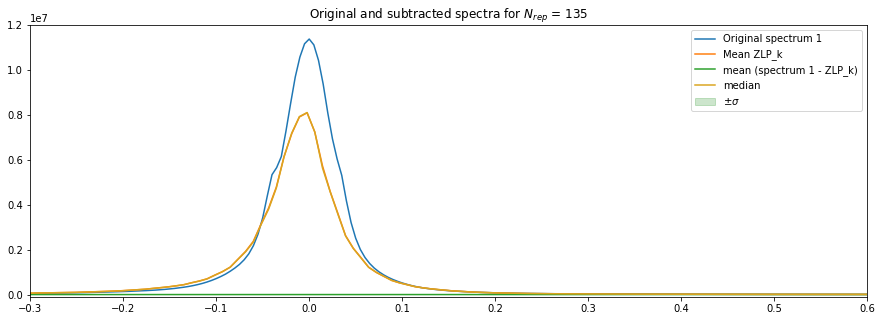

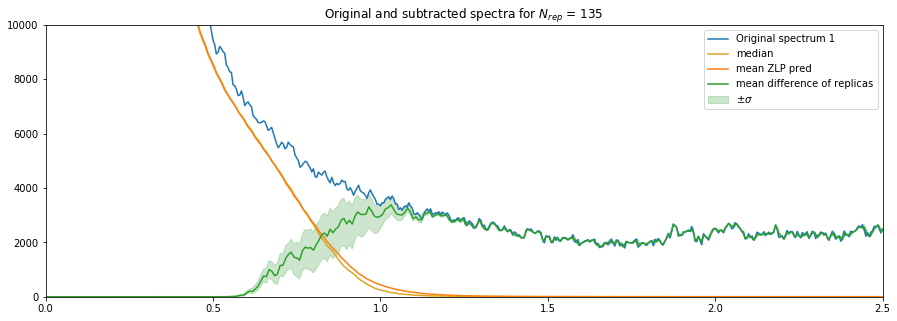

In [609]:
plt.figure(figsize=(15,5))
plt.plot(original['x1'], original['y1'], label='Original spectrum 1')
plt.plot(mean_replicas['x'], mean_replicas['pred'], label='Mean ZLP_k')
plt.plot(mean_replicas['x'], mean_replicas['dif1'], label='mean (spectrum 1 - ZLP_k)')
plt.plot(mean_replicas['x'], mean_replicas['median'], label='median', color='goldenrod')
plt.fill_between(mean_replicas['x'], mean_replicas['dif1'] + mean_replicas['sigma_dif1'], \
                 mean_replicas['dif1'] - mean_replicas['sigma_dif1'], color='green',alpha=.2, label='$\pm \sigma$')
plt.title("Original and subtracted spectra for $N_{rep}$ = %(s)s" %{"s": len(use_files)})
plt.xlim([-.3,.6])
plt.ylim([-1e5, 1.2e7])
plt.legend()
plt.savefig('Data/Results/Subtracted_spectra.png')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(original['x1'], original['y1'], label='Original spectrum 1')
plt.plot(mean_replicas['x'], mean_replicas['median'], label='median', color='goldenrod')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas['pred'], label='median ZLP pred')
plt.plot(np.linspace(-.3, 3, nbins), mean_replicas['dif1'], label='mean difference of replicas')
plt.fill_between(np.linspace(-.3, 3, nbins), mean_replicas['high1'], \
                 mean_replicas['low1'], color='green',alpha=.2, label='$\pm \sigma$')
plt.title("Original and subtracted spectra for $N_{rep}$ = %(s)s" %{"s": len(use_files)})
plt.legend()
plt.xlim([0,2.5])
plt.ylim([0, 1e4])
plt.savefig('Data/Results/Subtracted_spectra(rescale).png')
plt.legend()
plt.show()

In [610]:
(dE1, dE2)

(0.685, 1.715)

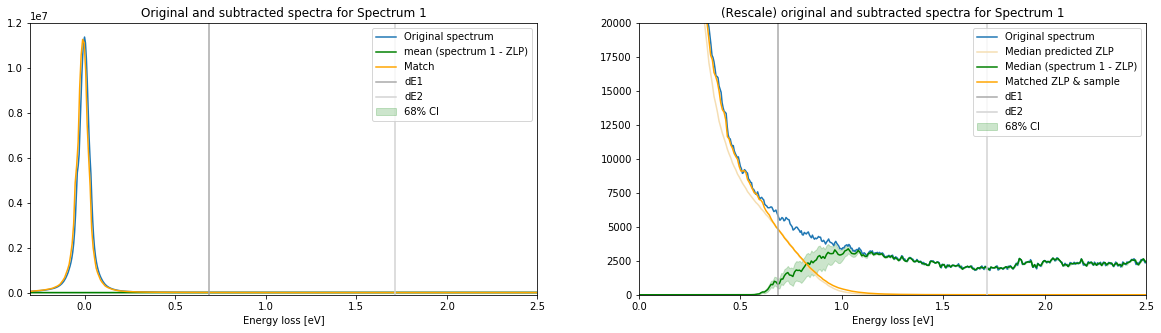

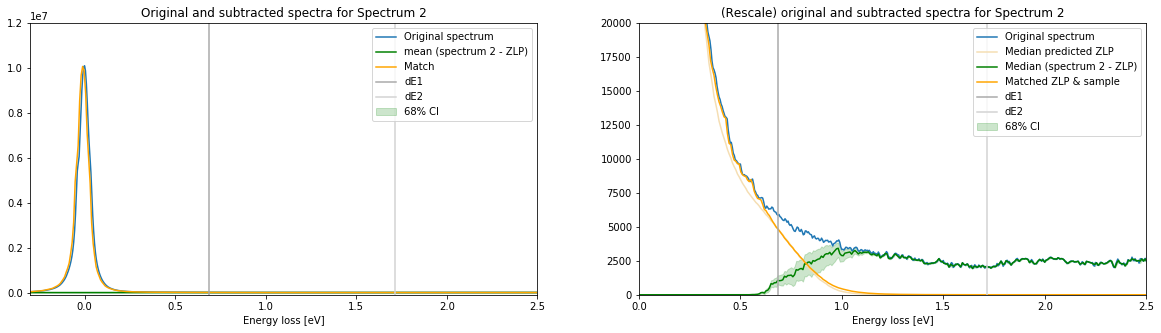

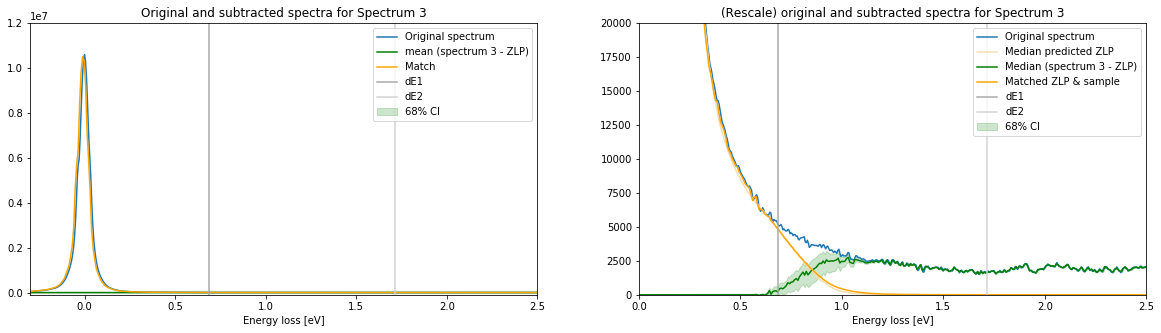

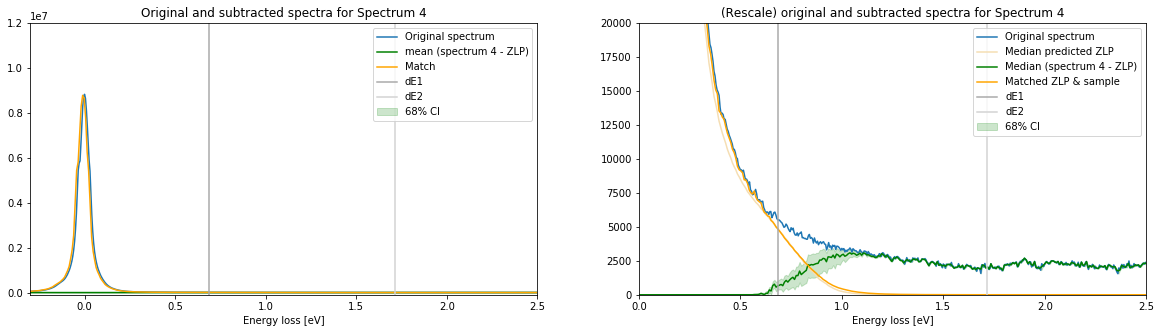

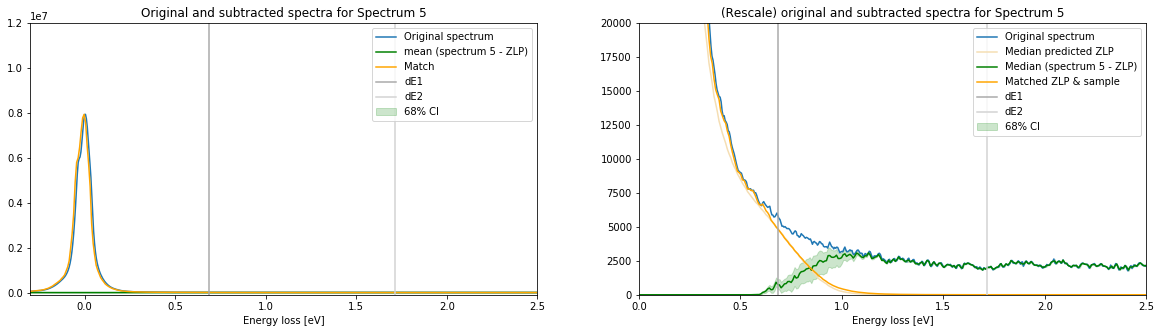

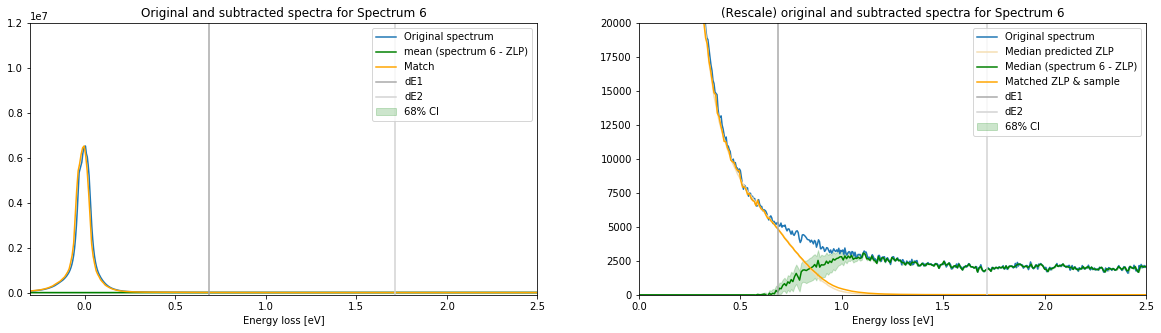

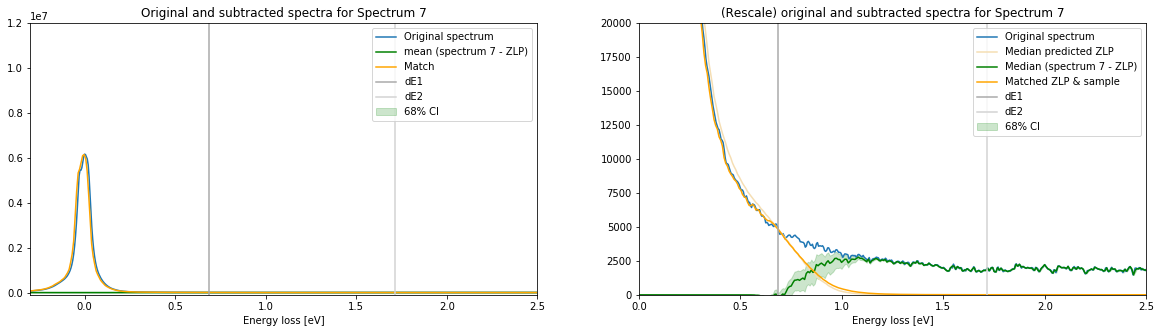

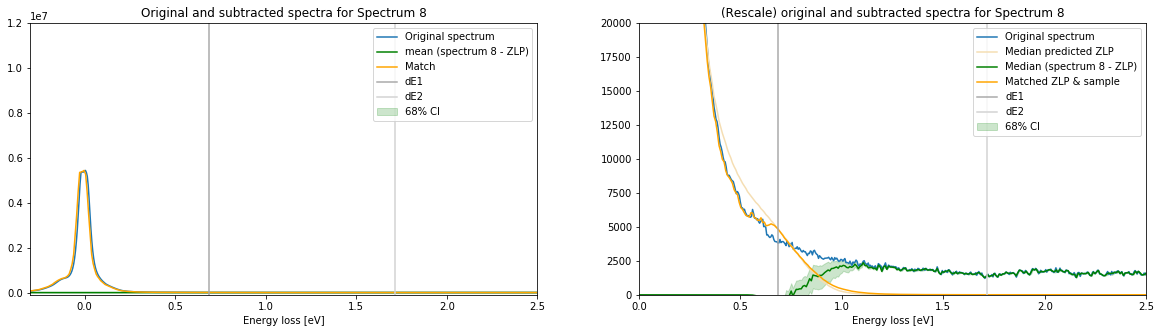

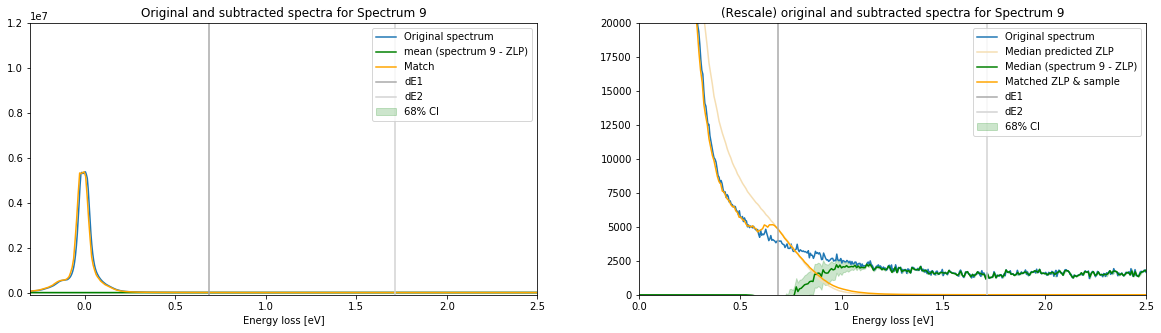

In [621]:
dE1 = max(training_data['x'][(training_data['x']< 1)])
dE2 = min(training_data['x'][(training_data['x']> 1)])


for i in ('1', '2', '3', '4', '5', '6', '7', '8', '9'):
    
    plt.figure(figsize=(20,5))
    
    plt.subplot(121)
    plt.plot(original['x1'], original['y'+i], label='Original spectrum ')
   # plt.plot(mean_replicas['x'], mean_replicas['pred'], label='Mean predicted ZLP')
    plt.plot(mean_replicas['x'], mean_replicas['dif'+i], color='green',label='mean (spectrum %(i)s - ZLP)' % {"i": i})
    plt.plot(mean_replicas['x'], mean_replicas['match'+i], label='Match', color='orange')
    plt.fill_between(mean_replicas['x'], mean_replicas['high'+i], \
                     mean_replicas['low'+i], color='green',alpha=.2, label='68% CI')
    plt.title("Original and subtracted spectra for Spectrum %(i)s" %{"i": i})
    plt.axvline(x=dE1, label='dE1', linestyle='-', color='darkgray')
    plt.axvline(x=dE2, label='dE2', linestyle='-', color='lightgray')
    plt.xlim([-.3,2.5])
    plt.ylim([-1e5, 1.2e7])
    plt.xlabel('Energy loss [eV]')
    plt.legend(loc='upper right')
    
    
    plt.subplot(122)
    plt.plot(original['x1'], original['y'+i], label='Original spectrum ')
    plt.plot(mean_replicas['x'], mean_replicas['median'], color='wheat',label='Median predicted ZLP')
    plt.plot(mean_replicas['x'], mean_replicas['dif'+i], color='green',label='Median (spectrum %(i)s - ZLP)' % {"i": i})
    plt.plot(mean_replicas['x'], mean_replicas['match'+i], label='Matched ZLP & sample', color='orange')
    plt.fill_between(mean_replicas['x'], mean_replicas['high'+i], \
                     mean_replicas['low'+i], color='green',alpha=.2, label='68% CI')
    plt.axvline(x=dE1, label='dE1', linestyle='-', color='darkgray')
    plt.axvline(x=dE2, label='dE2', linestyle='-', color='lightgray')
    plt.title("(Rescale) original and subtracted spectra for Spectrum %(i)s" %{"i": i})
    plt.xlim([0,2.5])
    plt.ylim([0, 2e4])
    plt.xlabel('Energy loss [eV]')
    plt.legend(loc='upper right')
    plt.savefig('Data/Results/Subtracted_spectra_%(i)s.png' % {"i": i})
    plt.show()

## Report

Create a standardized report file with the main outcomes

In [622]:
import sys
import base64
from prettytable import PrettyTable
pt = PrettyTable

d_string = '03.06.2020_2'

reportname = r'Reports/%(date)s_%(i)s_chi2=%(chi)s.html' % {"date": d_string, "i": round_no, "chi": selection_min }
sys.stdout = open(reportname,'w')

print((d_string )+ 'round' + str( round_no ) + '<br />')
print('Subtraction of original spectrum 1 <br /><br />')

list1 = ['Training window:', 'Pseudo data added in range:']
list2 = [str([-.3, max(training_data['x'][(training_data['x']< 1)])]) +' eV', \
         str([min(training_data['x'][(training_data['x']> 1)]), max(training_data['x'][(training_data['x']>1)])]) + 'eV']
for x in range(0,2):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 


list1 = ['Total no. of replicas:', 'Criterium Chi2:', 'Used no. of replicas:']
list2 = [len(all_files), selection_min, len(use_files)]

for x in range(0,3):
    print('%(s1)s %(s2)s <br />' % {"s1": list1[x], "s2": list2[x]}) 

In [623]:
plot1 = r'Data/Results/Example_individual_replicas.png'
plot2 = r'Data/Results/Example_individual_replicas(rescale).png'

plot3 = r'Data/Results/histogram.png'
plot4 = r'Data/Results/Subtracted_spectra.png'
plot5 = r'Data/Results/Subtracted_spectra(rescale).png'

plot6 = r'Data/Results/Ratio.png'
plot7 = r'Data/Results/Logratio.png'

plot8 = r'Data/Results/Log-ratio-sigma.png'



data_uri3 = base64.b64encode(open(plot3, 'rb').read()).decode('utf-8')
data_uri4 = base64.b64encode(open(plot4, 'rb').read()).decode('utf-8')
data_uri5 = base64.b64encode(open(plot5, 'rb').read()).decode('utf-8')
data_uri6 = base64.b64encode(open(plot6, 'rb').read()).decode('utf-8')
data_uri7 = base64.b64encode(open(plot7, 'rb').read()).decode('utf-8')
data_uri8 = base64.b64encode(open(plot8, 'rb').read()).decode('utf-8')

img_tag3 = '<img src="data:image/png;base64,{0}">'.format(data_uri3)
img_tag4 = '<img src="data:image/png;base64,{0}">'.format(data_uri4)
img_tag5 = '<img src="data:image/png;base64,{0}">'.format(data_uri5)
img_tag6 = '<img src="data:image/png;base64,{0}">'.format(data_uri6)
img_tag7 = '<img src="data:image/png;base64,{0}">'.format(data_uri7)
img_tag8 = '<img src="data:image/png;base64,{0}">'.format(data_uri8)

print(img_tag3)

print(img_tag6)
print(img_tag7)

for i in range(1,10):
    plot1 = r'Data/Results/Subtracted_spectra_%(i)s.png' % {"i": i}
    uri1 = base64.b64encode(open(plot1, 'rb').read()).decode('utf-8')
    tag1 = '<img src="data:image/png;base64,{0}">'.format(uri1)
    print(tag1)
    
print(img_tag8)


